# Regresión lineal para predecir los gastos médicos de pacientes

Utilizando como inicio datos del US Census Bureau se recabaron datos de gastos en seguros de datos médicos de varios pacientes

| Variable                | Tipo            | Descripción                                |
|-------------------------|-----------------|--------------------------------------------|
| Edad                    | Numérica        | La edad del asegurado                      |
| Sexo                    | Dicotómica      | Género binario del asegurado               |
| Índice de masa corporal | Numérica        | Índice de masa corporal del paciente       |
| Hijos                   | Numérica entera | Cantidad de hijos del paciente             |
| Fumador                 | Booleana        | Si el paciente es fumador o no fumador     |
| Región                  | Categórica      | Región en la que vive el paciente          |
| Cargos                  | Numérica        | La cantidad que pagó de seguro el paciente |

Fuente: https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download

# Exploración y preparación de datos

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [1]:
!pip install regressors

     |████████████████████████████████| 9.8 MB 24.2 MB/s 
     |████████████████████████████████| 233 kB 43.2 MB/s 
  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12374 sha256=932f55973e9f2d558f6784fd077c3c535c475275646a00c164697161678325e5
  Stored in directory: /root/.cache/pip/wheels/5e/84/7d/c7f674a24c508709cdd3aa6cf0f129899f21061b2821ceed32
Successfully built regressors
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import seaborn as sns

sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [3]:
df = pd.read_csv('/work/db/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1338, 7)


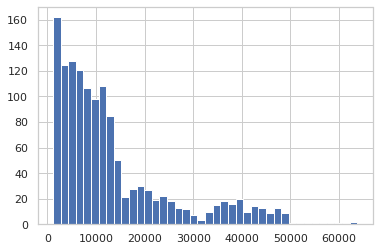

In [4]:
print(df.shape)

## Histograma de los gastos médicos
df.charges.hist(bins = 40);

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [5]:
df[df.charges > 50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


Por motivos didácticos, se eliminarán estos datos con cargos arriba de 50,000. Sin embargo, se recomienda consultar con un experto si vale la pena eliminar estos datos.

In [6]:
df = df[df.charges < 50000]

Otra variable interesante a analizar es la edad, podemos que ver tenemos un mayor conteo de datos de personas menores de 20 años y menor cantidad de datos para las personas mayores de edad.

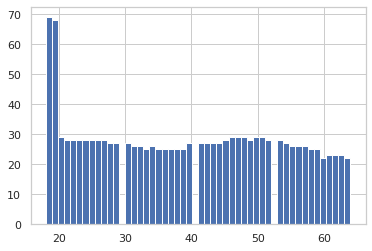

In [7]:
df.age.hist(bins = 50);

# Análisis de correlación de los datos
Ahora entendamos nuestros datos viendo cómo se distribuyen y correlacionan.

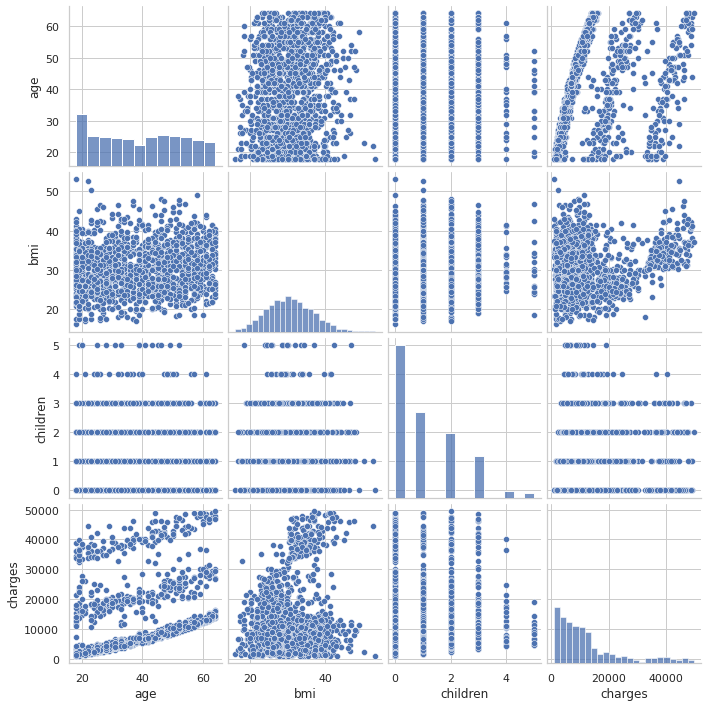

In [8]:
import matplotlib.pyplot as plt
sns.pairplot(df, height=2.5)
plt.show()

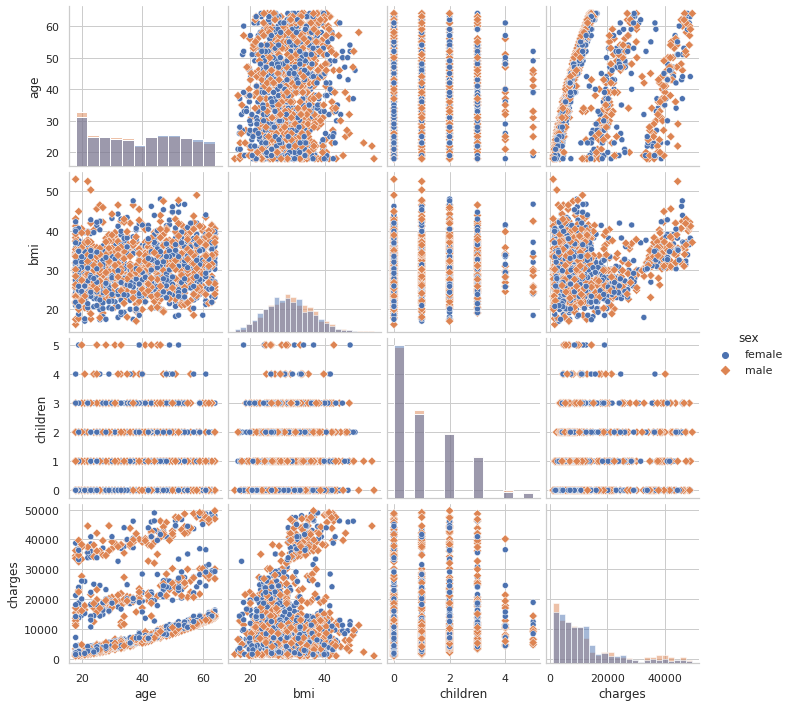

In [9]:
sns.pairplot(df, height=2.5, hue='sex', markers=['o', 'D'], diag_kind="hist")
plt.show()

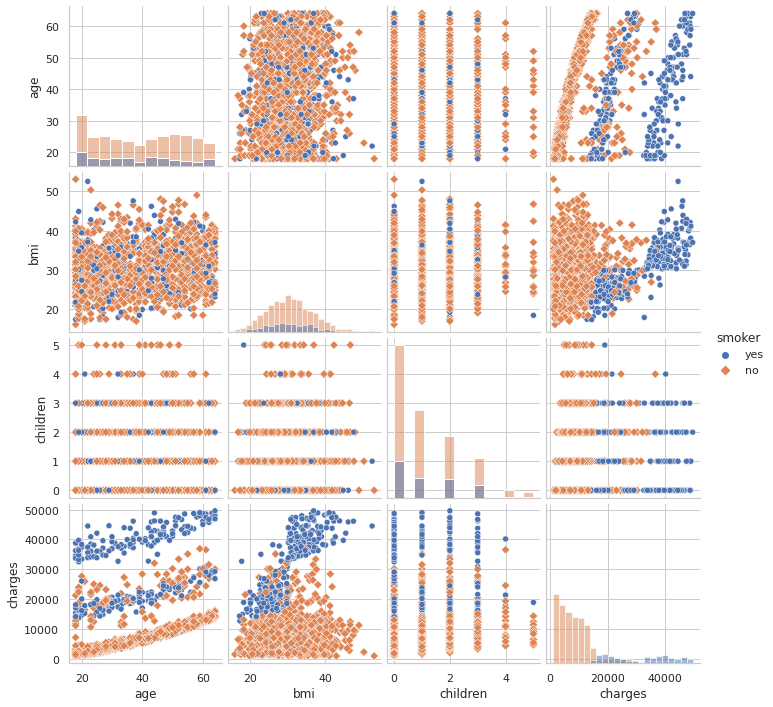

In [10]:
sns.pairplot(df, height=2.5, hue='smoker', markers=['o', 'D'], diag_kind="hist")
plt.show()

In [11]:
df.region.value_counts()

southeast    362
southwest    323
northwest    323
northeast    323
Name: region, dtype: int64

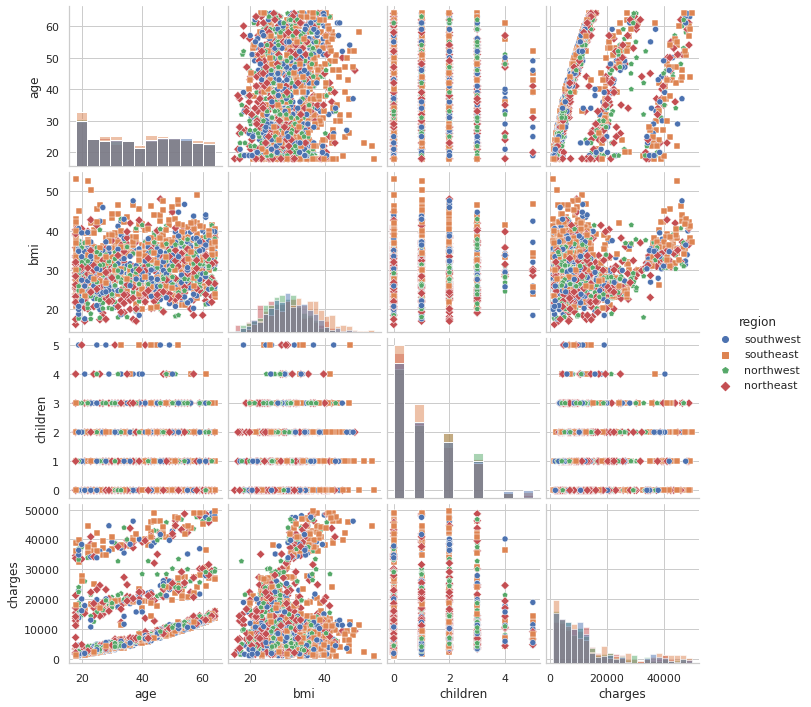

In [12]:
sns.pairplot(df, height=2.5, hue='region', markers=['o', 's', 'p', 'D'], diag_kind="hist")
plt.show()

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos. Como se puede ver de manera visual en los pairplots, la variable categórica que más tiene correlación es si la persona es fumadora o no.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

**Matriz de correlación**

En la siguiente matriz de correlación en donde se utilizan los datos sin ningún filtro, se pueden observar coeficientes de correlación muy bajos.

<AxesSubplot:>

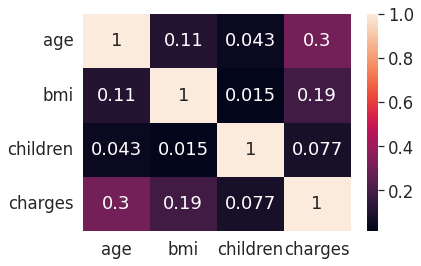

In [13]:
import numpy as np
numeric_cols = ['age', 'bmi', 'children', 'charges']
cm = df.corr()
sns.set(font_scale=1.5)
sns.heatmap(cm ,annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)

Ahora vemaos las correlaciones al separar los datos en personas fumadoras y no fumadoras

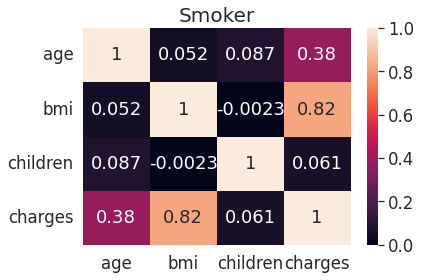

In [14]:
## Separando los datos
df_smoker = df[df.smoker == 'yes']
df_no_smoker = df[df.smoker == 'no']

## Heatmap para personas fumadoras
sns.heatmap(df_smoker.corr() ,annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)
plt.title("Smoker", fontsize =20)
plt.show()

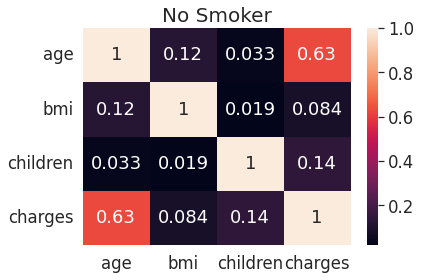

In [15]:
## Heatmap para personas no fumadoras
sns.heatmap(df_no_smoker.corr() ,annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)
plt.title("No Smoker", fontsize =20)
plt.show()

De acuerdo a esto, se pueden observar qué influye más en los gatos médicos de acuerdo si la persona fuma o no. Estos son:

- Las personas fumadoras tienden a tener más gatos médicos conforme su bmi aumenta.

- En cambio, las personas no fumadoras esta muchisímo más correlacionado con la edad que con su bmi.

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función **[get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)** de pandas. 

In [16]:
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


# Entrenamiento del modelo

Primero se usará un modelo con todas las variables. 

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Se crean 2 sets de datos: (1) un set de entrenamiento para ajustar el modelo, y (2) un set de prueba para la evaluación del mismo.

In [18]:
X_cols = list(set(df.columns)-set(['charges']))
y_col = ['charges']

X = df[X_cols].values
y = df[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
# Entrenando el modelo
model.fit(X_train, y_train)

# Predicción
y_pred = model.predict(X_test)

In [19]:
y_pred.shape

(333, 1)

# Evaluando el modelo
El siguiente punto es calcular las métricas del modelo.

In [20]:
import sklearn.metrics as metrics

mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"""r2: {r2.round(4)}
mse: {mse.round(4)}
""")

r2: 0.7395
mse: 0.2764



El siguiente código muestra un resumen general de los resultados.

In [21]:
from regressors import stats
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [22]:
y_test = y_test.reshape(-1)

print("========= S U M A R Y =========")
stats.summary(model, X_test, y_test, X_cols)

========= S U M A R Y =========
Residuals:
    Min      1Q  Median     3Q    Max
-2.0577 -0.1211   0.067 0.2005 0.8755


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.015293    0.028991  -0.5275  0.598194
children          0.052209    0.030520   1.7107  0.088079
region_southeast -0.030497    0.034046  -0.8958  0.371022
sex_male         -0.001812    0.028968  -0.0626  0.950160
region_southwest -0.032183    0.035368  -0.9099  0.363513
bmi               0.165554    0.031133   5.3176  0.000000
smoker_yes        0.787699    0.030346  25.9571  0.000000
region_northwest -0.004816    0.033147  -0.1453  0.884573
age               0.315911    0.027943  11.3055  0.000000
---
R-squared:  0.73945,    Adjusted R-squared:  0.73302
F-statistic: 114.94 on 8 features


Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

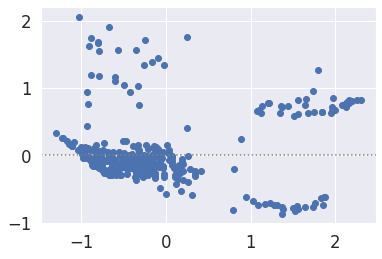

In [23]:
residual = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residual)
plt.axhline(0, color='gray', linestyle='dotted')
plt.show()

# Mejorando el modelo

Estos resultados de arriba son buenos, pero se pueden mejorar. 
Hasta ahora, hemos utilizado todas las variables de nuestro dataset para realizar nuestro modelo, lo cual no es muy recomendable.

Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [24]:
df_second = df.copy()
df_second['age2'] = df_second.age**2
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes

Por ahora, vamos a utilizar nuevamente todas las variables para ver su cambio

In [25]:
X_cols = list(set(df_second.columns)-set(['charges']))
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [26]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2: ", r2.round(4))
print("mse: ", mse.round(4))

r2:  0.8382
mse:  0.1482


In [27]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [28]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
   Min     1Q  Median     3Q    Max
-1.973 0.0634  0.1141 0.1382 1.4348


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.001184    0.021260   0.0557  0.955638
children           0.064368    0.020849   3.0874  0.002190
region_southeast  -0.030975    0.026009  -1.1909  0.234524
sobrepeso         -0.018314    0.031616  -0.5792  0.562814
sex_male          -0.017919    0.021493  -0.8337  0.405038
region_southwest  -0.047531    0.024707  -1.9238  0.055234
sobrepeso*fumador  0.480934    0.030847  15.5909  0.000000
bmi                0.047146    0.031464   1.4984  0.134981
smoker_yes         0.476875    0.027523  17.3265  0.000000
age2               0.356906    0.106215   3.3602  0.000870
region_northwest  -0.010727    0.024613  -0.4358  0.663259
age               -0.029523    0.109717  -0.2691  0.788030
---
R-squared:  0.83821,    Adjusted R-squared:  0.83267
F-statistic: 151.19 on 11 features


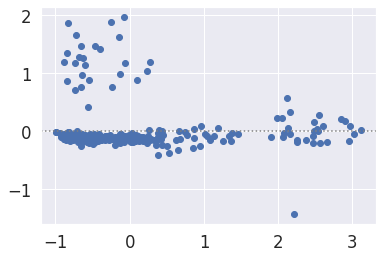

In [29]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='gray', linestyle='dotted')
plt.show()

Vemos que nuestro indicador R^2 mejoró. Sin embargo, podemos eliminar todas la variables que tengan un p-value mayor a 0.05

In [30]:
X_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children']
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression(fit_intercept=False)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [31]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2: ", r2.round(4))
print("mse: ", mse.round(4))

model.coef_ = model.coef_.reshape(-1)

r2:  0.8448
mse:  0.1497


In [32]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median    3Q    Max
-1.8121 0.0591  0.1083 0.137 0.3239


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.021320   0.0000  1.000000
sobrepeso*fumador  0.504617    0.026828  18.8095  0.000000
smoker_yes         0.450054    0.024801  18.1467  0.000000
age2               0.322833    0.021630  14.9250  0.000000
children           0.071937    0.022039   3.2641  0.001212
---
R-squared:  0.84477,    Adjusted R-squared:  0.84288
F-statistic: 446.24 on 4 features


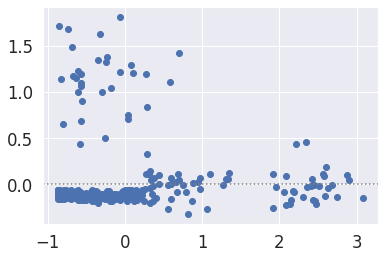

In [33]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='gray', linestyle='dotted')
plt.show()

Como hemos visto, ahora vemos en nuestra gráfica de residuos que los datos de predicción están más acercados a la línea horizontal en cero, además de que nuestra R^2 mejoró.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8b8beb45-6e9e-4db8-96c9-28634efc9b59' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>